In [28]:
import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

from duration_processor import load_quiz_data

# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

from quiz_evaluator import (
    analyze_nasa_and_post_surveys,
    plot_nasa_tlx_by_format,
    test_post_task_metrics,
    test_nasa_metrics_by_format,
    process_clean_post_tasks

)

# 假设 all_data 已加载
df_nasa = analyze_nasa_and_post_surveys(all_data)
df_nasa

,participantId,format,startTime,endTime,duration_sec,mental-demand,physical-demand,temporal-demand,performance,effort,frustration
0,64457bc906c125cebd4bf66b,json5,1746562427809,1746562451027,23.218,93,11,55,10,75,94
1,6697c8b6d9d7baa7edd8c4d3,hjson,1745933947314,1745933980430,33.116,90,20,50,55,50,75
2,67e25388d573ec2d5f1c8442,yaml,1746148170240,1746148206380,36.140,90,100,70,0,95,5
3,67e5cf90b79d0874e1cf16b0,toml,1746147492250,1746147510048,17.798,97,90,92,78,99,61
4,67d00f24466a67ba7e41228e,toml,1745933364792,1745933382986,18.194,79,77,63,18,98,75
...,...,...,...,...,...,...,...,...,...,...,...
101,67ab650c320eccf6141d4010,jsonc,1746147500734,1746147519483,18.749,65,61,59,57,60,62
102,65fad673a546ab14baf2f8d3,json5,1745932106163,1745932137658,31.495,85,80,85,80,85,75
103,67f1c7bd6f1c4a3d8deae02f,toml,1746146632834,1746146718970,86.136,85,60,20,10,100,10
104,67adb27bd5f5776fcb16da62,hjson,1746147510098,1746147559334,49.236,85,75,85,60,80,55


In [29]:
res = test_nasa_metrics_by_format(df_nasa)

for metric, info in res.items():
    print(info['interpretation'])
    if info['tukey'] is not None:
        print(info['tukey'].summary())

Metric 'mental-demand': Levene’s test p = 0.151 (homogeneous) variances. ANOVA p = 0.002 (< 0.05): significant differences among formats. See Tukey HSD for pairwise comparisons.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
 hjson   json  22.3451 0.0008   6.6679 38.0223   True
 hjson  json5  18.8667 0.0115    2.707 35.0264   True
 hjson  jsonc  13.7333 0.1506  -2.4264  29.893  False
 hjson   toml  19.3619 0.0105   2.9162 35.8076   True
 hjson    xml     16.8 0.0361   0.6403 32.9597   True
 hjson   yaml  14.3333 0.1171  -1.8264  30.493  False
  json  json5  -3.4784  0.994 -19.1556 12.1988  False
  json  jsonc  -8.6118 0.6483  -24.289  7.0654  False
  json   toml  -2.9832 0.9977 -18.9551 12.9887  False
  json    xml  -5.5451 0.9369 -21.2223 10.1321  False
  json   yaml  -8.0118 0.7212  -23.689  7.6654  False
 json5  jsonc  -5.1333  0.962  -21.293 11.0264  False
 json5   tom

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def report_nasa_tlx_analysis(
    df_nasa: pd.DataFrame,
    format_list: list = None,
    metrics: list = None,
    group_col: str = 'format',
    alpha: float = 0.05
):
    """
    Combined report for NASA-TLX data with numeric coercion for plotting:
      1) Print significance test interpretations for each metric
      2) Summarize which metrics have significant differences (and Tukey pairs)
      3) Plot bar chart of average metrics by format
      4) Plot boxplots for each metric by format (ensuring numeric dtype)
    """
    # 1) Run tests
    results = test_nasa_metrics_by_format(
        df_nasa,
        metrics=metrics,
        format_list=format_list,
        group_col=group_col,
        alpha=alpha
    )

    # 2) Print interpretations
    print("=== Interpretations of Significance Tests ===")
    for metric, info in results.items():
        print(info['interpretation'])
    print()

    # 3) Summary lists
    sig_metrics = [m for m, info in results.items() if info['p_value'] < alpha]
    nonsig_metrics = [m for m, info in results.items() if info['p_value'] >= alpha]
    print("Metrics with significant differences:", sig_metrics)
    print("Metrics without significant differences:", nonsig_metrics)
    # For those with Tukey HSD, list significant pairs
    for m in sig_metrics:
        info = results[m]
        if info['method'] == 'ANOVA' and info['tukey'] is not None:
            pairs = [
                f"{r[0]} vs {r[1]}"
                for r in info['tukey'].summary().data[1:]
                if r[-1] in (True, 'True')
            ]
            print(f"  • {m}: Tukey significant pairs → {pairs}")
    print()

    # 4) Bar chart of average values
    fig = plot_nasa_tlx_by_format(df_nasa, format_list=format_list, metrics=(['duration_sec'] + (metrics or [])))
    plt.show()

    # 5) Boxplots for each metric
    all_metrics = metrics or [
        'duration_sec',
        'mental-demand',
        'physical-demand',
        'temporal-demand',
        'performance',
        'effort',
        'frustration'
    ]
    if format_list is not None:
        df_plot = df_nasa[df_nasa[group_col].isin(format_list)].copy()
    else:
        df_plot = df_nasa.copy()

    # Coerce to numeric before plotting
    df_plot[all_metrics] = df_plot[all_metrics].apply(pd.to_numeric, errors='coerce')

    print("=== Boxplots of Metrics by Format ===")
    for metric in all_metrics:
        if metric not in df_plot.columns:
            continue
        df_nonan = df_plot.dropna(subset=[metric])
        if df_nonan.empty:
            print(f"Skipping '{metric}' (no numeric data).")
            continue
        plt.figure(figsize=(6,4))
        sns.boxplot(x=group_col, y=metric, data=df_nonan, showfliers=False)
        sns.stripplot(x=group_col, y=metric, data=df_nonan, color='black', size=3, alpha=0.6)
        plt.title(f"{metric} by {group_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return results


=== Interpretations of Significance Tests ===
Metric 'mental-demand': Levene’s test p = 0.151 (homogeneous) variances. ANOVA p = 0.002 (< 0.05): significant differences among formats. See Tukey HSD for pairwise comparisons.
Metric 'physical-demand': Levene’s test p = 0.659 (homogeneous) variances. ANOVA p = 0.295 (≥ 0.05): no significant differences among formats.
Metric 'temporal-demand': Levene’s test p = 0.239 (homogeneous) variances. ANOVA p = 0.006 (< 0.05): significant differences among formats. See Tukey HSD for pairwise comparisons.
Metric 'performance': Levene’s test p = 0.496 (homogeneous) variances. ANOVA p = 0.148 (≥ 0.05): no significant differences among formats.
Metric 'effort': Levene’s test p = 0.231 (homogeneous) variances. ANOVA p = 0.028 (< 0.05): significant differences among formats. See Tukey HSD for pairwise comparisons.
Metric 'frustration': Levene’s test p = 0.492 (homogeneous) variances. ANOVA p = 0.298 (≥ 0.05): no significant differences among formats.

Met

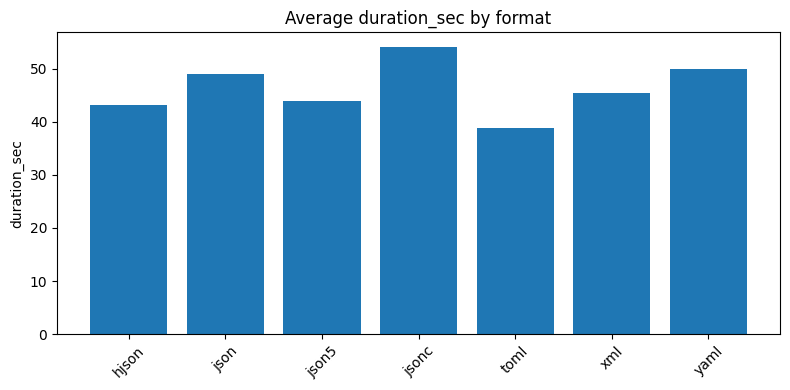

=== Boxplots of Metrics by Format ===


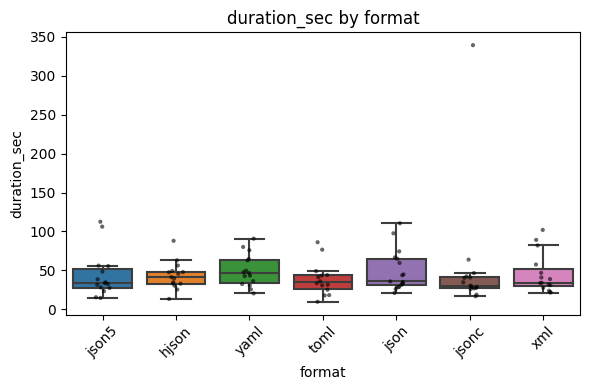

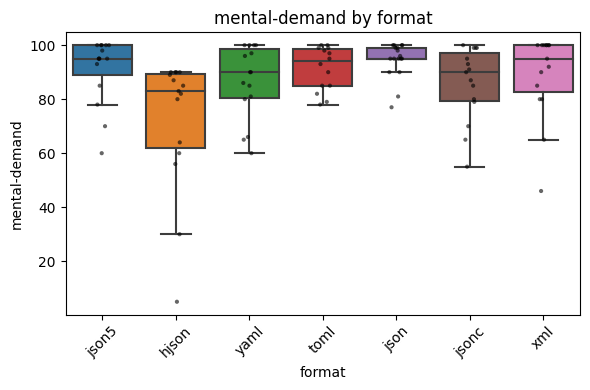

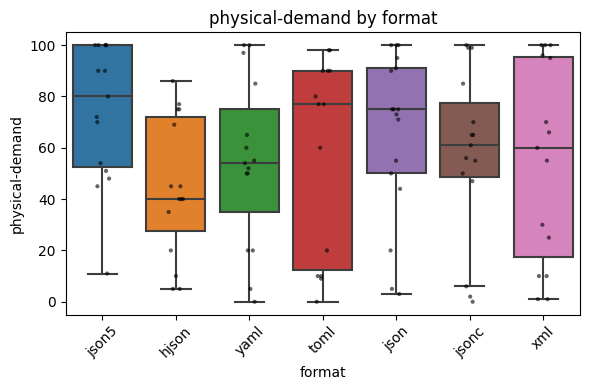

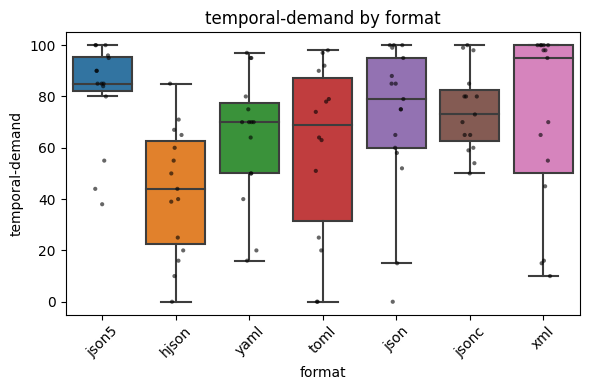

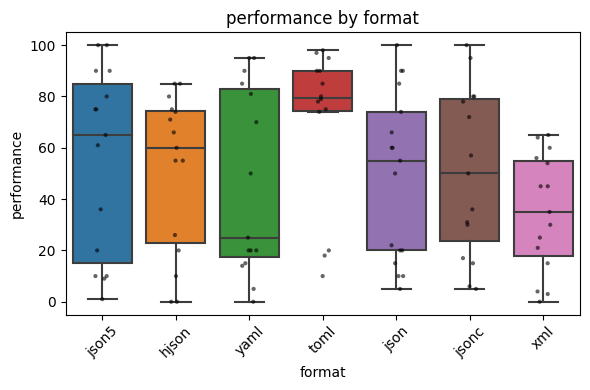

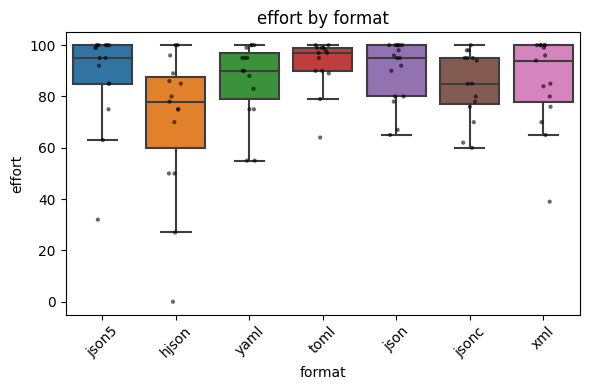

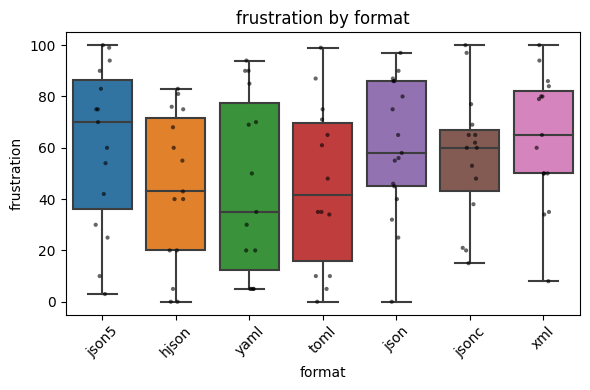

In [39]:
results = report_nasa_tlx_analysis(
    df_nasa,
    format_list=['hjson','json','yaml','json5','jsonc','toml','xml'],  # 或 None
    metrics=None,                        # 默认所有 NASA-TLX 维度
    group_col='format',
    alpha=0.05
)

/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_64305/1547689505.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_64305/1547689505.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


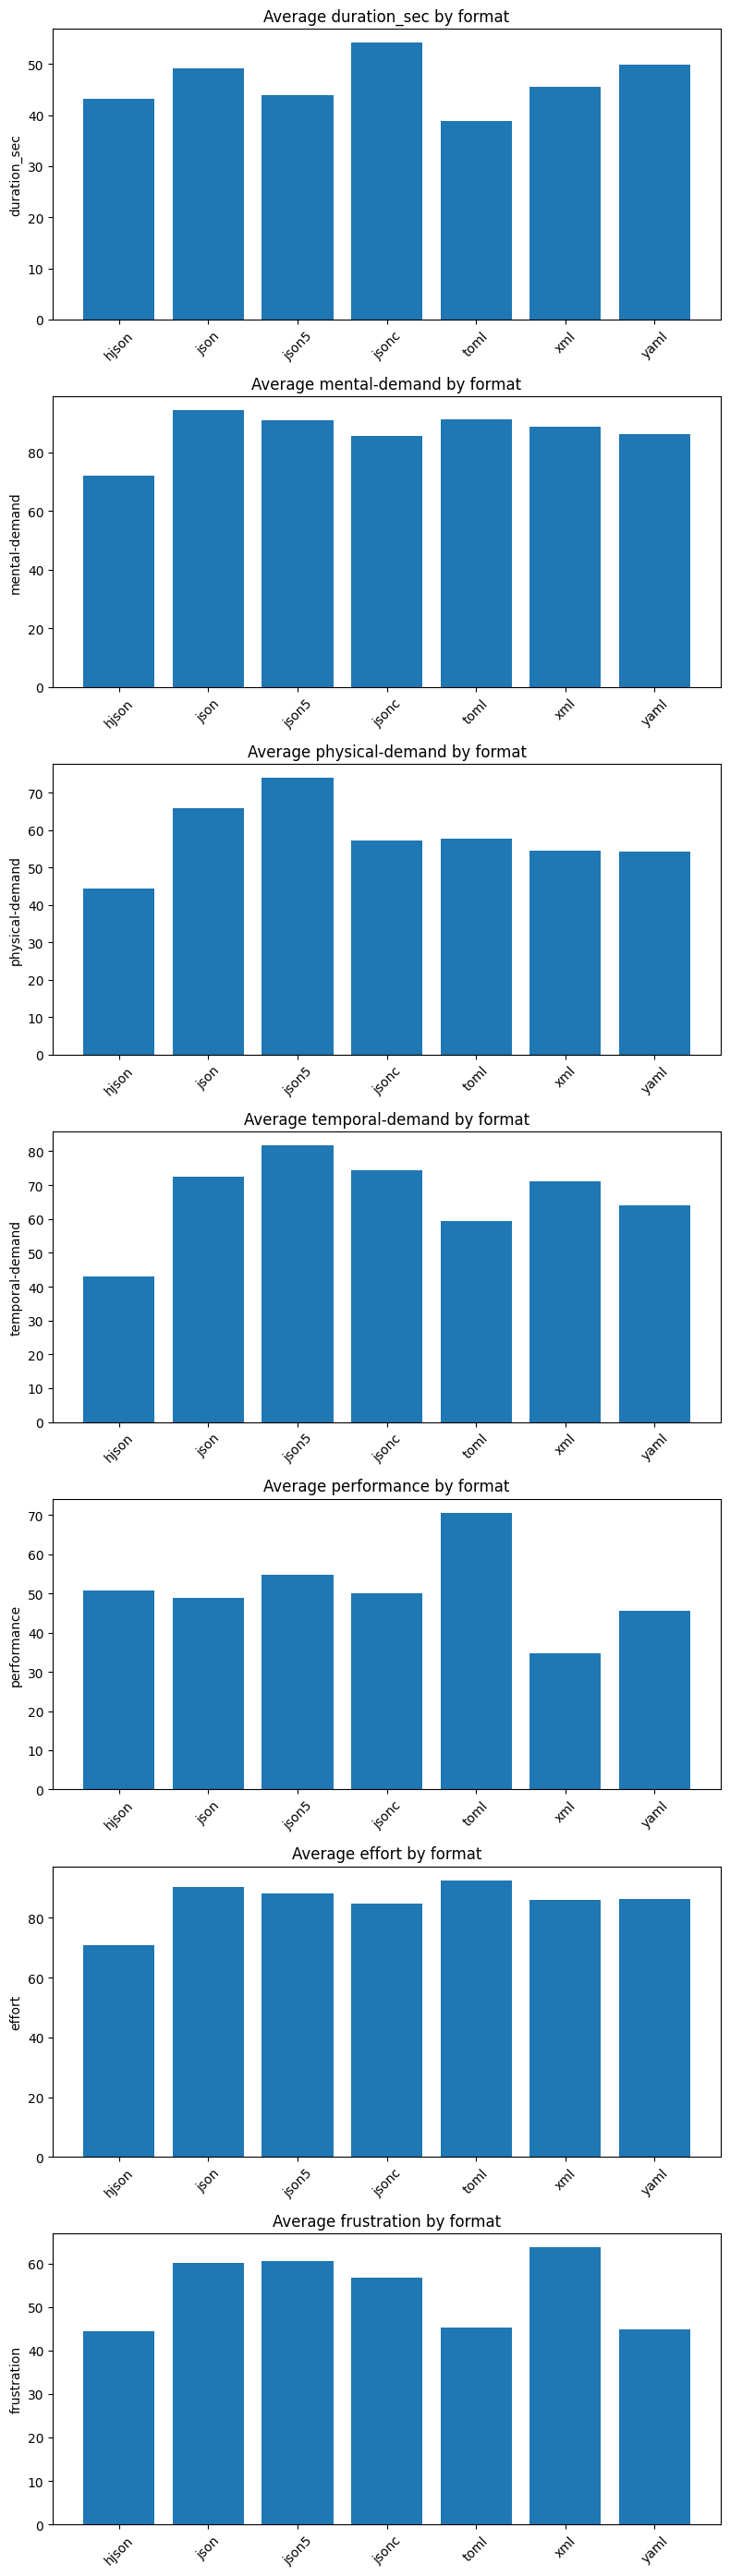

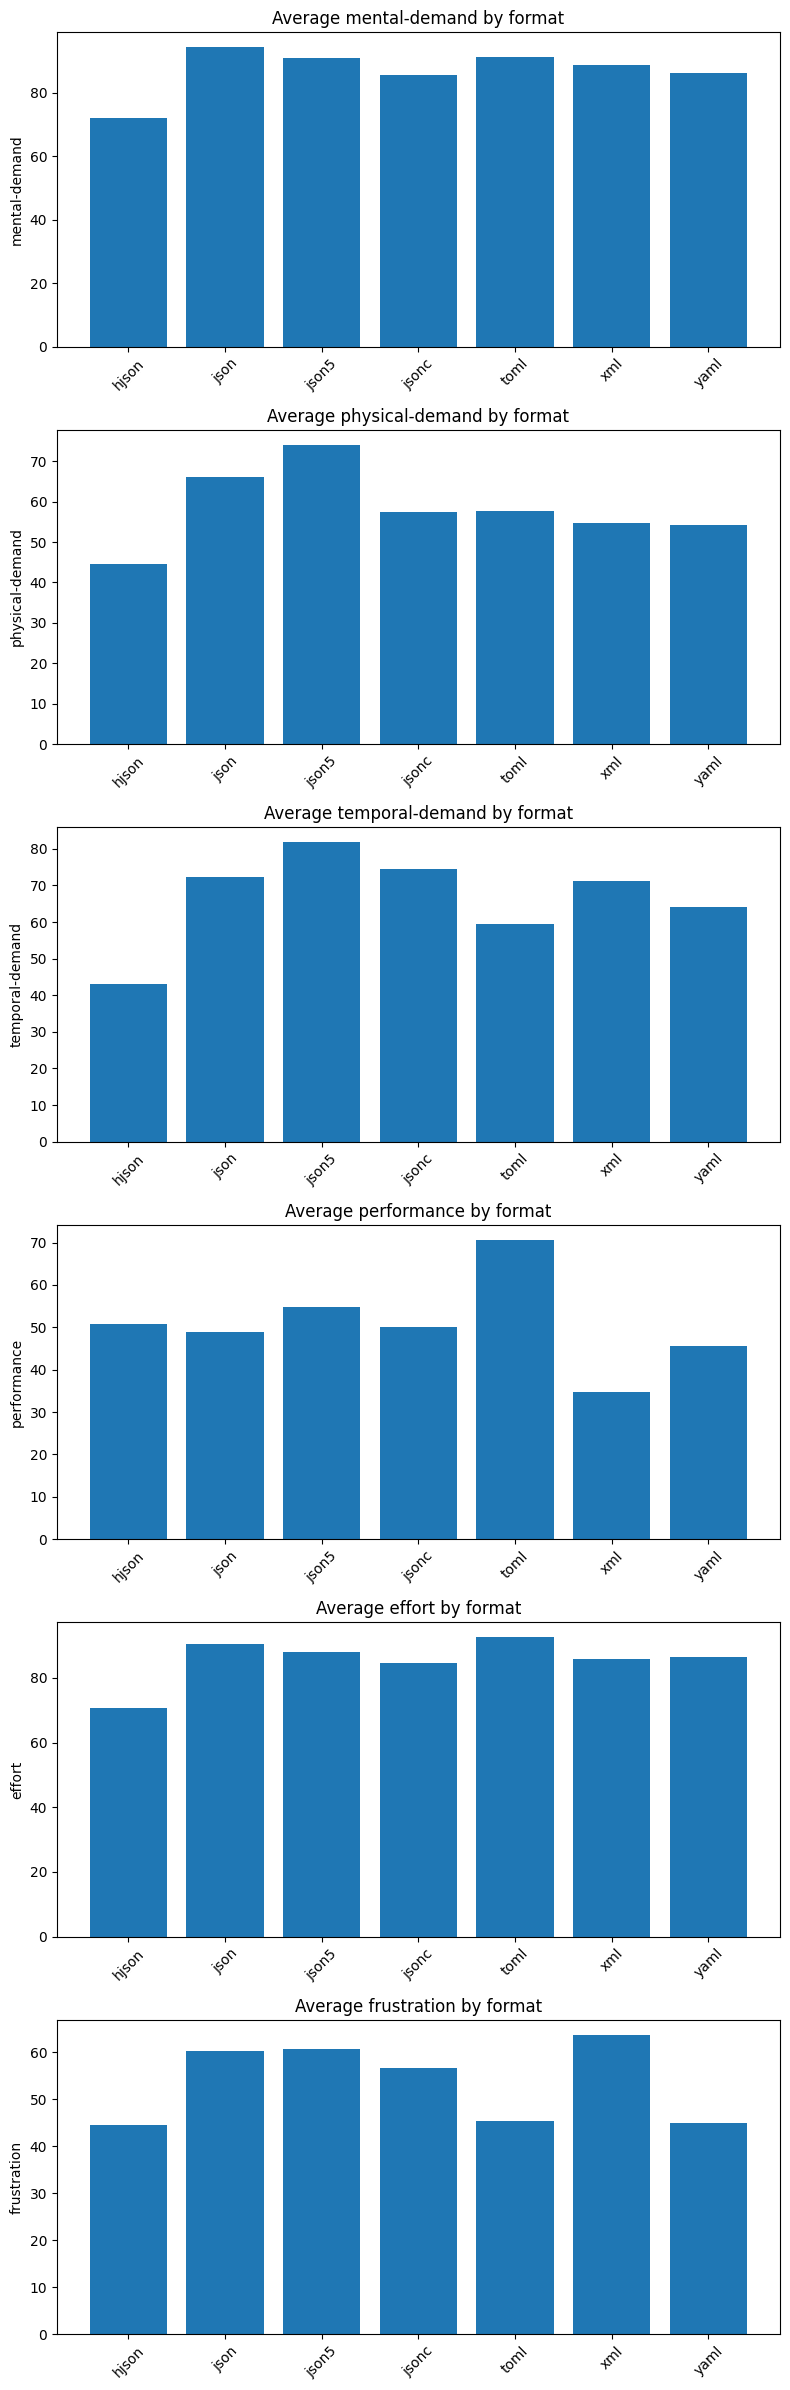

In [30]:
fig = plot_nasa_tlx_by_format(
    df_nasa,
    format_list=['json', 'xml', 'hjson', 'yaml','jsonc', 'json5', 'toml']
)
fig.show()

# 如果只想看时长和“努力（effort）”两个维度：
fig2 = plot_nasa_tlx_by_format(
    df_nasa,
    metrics = [
    'mental-demand',
    'physical-demand',
    'temporal-demand',
    'performance',
    'effort',
    'frustration'
]
)
fig2.show()


  format                      task  duration_sec  difficulty  confidence
0  hjson  modifying-task-tabular-1      6.687400    2.466667    5.933333
1  hjson  modifying-task-tabular-2      7.352933    2.066667    6.200000
2  hjson  modifying-task-tabular-3      5.550600    3.400000    4.733333
3  hjson  modifying-task-tabular-4      7.105933    4.266667    4.266667
4  hjson    reading-task-tabular-1      8.249200    1.733333    5.733333


/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_64305/1639020638.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


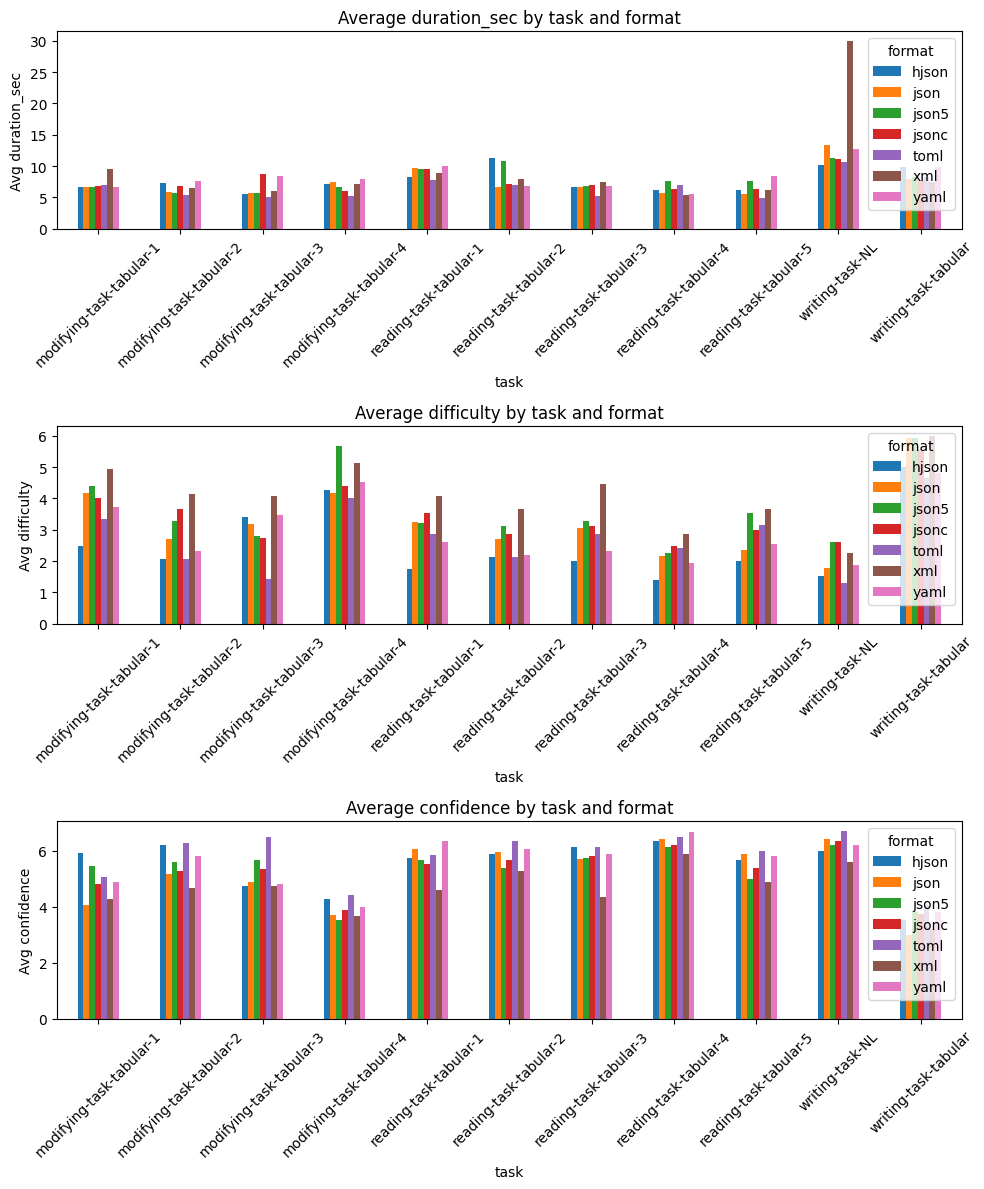

In [31]:
from quiz_evaluator import (
    extract_post_task_questions,
    plot_metrics_by_format_and_task,
    sanitize_task_names
)

df_post = extract_post_task_questions(all_data)

# 3. 查看 summary（可选）
df_clean = df_post.copy()
df_clean['task'] = sanitize_task_names(df_clean)['task']
summary = (
    df_clean
      .groupby(['format','task'])[['duration_sec','difficulty','confidence']]
      .mean()
      .reset_index()
)
print(summary.head())

# 4. 可视化：只看 json/xml/hjson 三种格式
fig = plot_metrics_by_format_and_task(
    df_post,
    format_list=['json', 'xml', 'hjson', 'yaml','jsonc', 'json5', 'toml'],
    metrics=['duration_sec','difficulty','confidence']
)
fig.show()


In [32]:
import pandas as pd
import re
from scipy.stats import levene, f_oneway, kruskal, shapiro
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# def test_format_duration(df_combined: pd.DataFrame, task_list: list, alpha: float = 0.05) -> dict:
#     """
#     For each raw_task in task_list:
#       1) Map to canonical task_group
#       2) Levene’s test → choose ANOVA or Kruskal–Wallis
#       3) Tukey HSD if ANOVA
#       4) Returns dict: raw_task -> stats
#     """
#     results = {}
#     for raw_task in task_list:
#         # determine canonical
#         canonical = raw_task
#         for prefix in ['modifying-task-tabular', 'reading-task-tabular', 'writing-task-tabular']:
#             if raw_task.startswith(prefix + '-'):
#                 canonical = prefix
#                 break
#         else:
#             if re.match(r'^tutorial-[^-]+-part\d+$', raw_task):
#                 canonical = re.sub(r'-part\d+$', '', raw_task)
#         sub = df_combined[df_combined['task_group'] == canonical]
#         if sub['format'].nunique() < 2:
#             continue
#         groups = [g['duration_sec'].values for _, g in sub.groupby('format')]
#         w_stat, p_levene = levene(*groups)
#         if p_levene > alpha:
#             stat, pval = f_oneway(*groups)
#             method = 'ANOVA'
#             tukey = pairwise_tukeyhsd(endog=sub['duration_sec'], groups=sub['format'], alpha=alpha)
#         else:
#             stat, pval = kruskal(*groups)
#             method = 'Kruskal–Wallis'
#             tukey = None
#         results[raw_task] = {
#             'canonical': canonical,
#             'levene': (w_stat, p_levene),
#             'method': method,
#             'stat': stat,
#             'p_value': pval,
#             'tukey': tukey
#         }
#     return results

# def generate_interpretation(results: dict, alpha: float = 0.05) -> dict:
#     """
#     Given test_format_duration results, produce English interpretation strings.
#     """
#     interpretations = {}
#     for raw_task, info in results.items():
#         w, p_levene = info['levene']
#         method = info['method']
#         stat = info['stat']
#         pval = info['p_value']
#         lines = [f"=== Task '{raw_task}' (as '{info['canonical']}') ===\n"]
#         if p_levene > alpha:
#             lines.append(f"Levene’s test p = {p_levene:.3f} (> {alpha}): variances homogeneous.\n")
#         else:
#             lines.append(f"Levene’s test p = {p_levene:.3f} (≤ {alpha}): variances heterogeneous.\n")
#         if method == 'ANOVA':
#             lines.append(f"One-way ANOVA: F = {stat:.3f}, p = {pval:.3f}.\n")
#             if pval < alpha:
#                 lines.append("→ p < 0.05: significant difference; see Tukey HSD for pairs.\n")
#             else:
#                 lines.append("→ p ≥ 0.05: no significant difference.\n")
#         else:
#             lines.append(f"Kruskal–Wallis: H = {stat:.3f}, p = {pval:.3f}.\n")
#             if pval < alpha:
#                 lines.append("→ p < 0.05: significant difference.\n")
#             else:
#                 lines.append("→ p ≥ 0.05: no significant difference.\n")
#         interpretations[raw_task] = "".join(lines)
#     return interpretations

# def summarize_significance(results: dict, alpha: float = 0.05) -> pd.DataFrame:
#     """
#     Summarize which tasks are significant and list Tukey pairs if ANOVA.
#     """
#     rows = []
#     for task, info in results.items():
#         pval = info['p_value']
#         sig = pval < alpha
#         pairs = []
#         if sig and info['method'] == 'ANOVA' and info['tukey'] is not None:
#             tbl = info['tukey'].summary().data[1:]
#             for r in tbl:
#                 if r[-1] in (True, 'True'):
#                     pairs.append(f"{r[0]} vs {r[1]}")
#         rows.append({'task': task, 'method': info['method'], 
#                      'p_value': pval, 'significant': sig, 'diff_pairs': pairs})
#     return pd.DataFrame(rows)

# def get_significance_lists(results: dict, alpha: float = 0.05) -> dict:
#     """
#     Return lists of tasks with and without significant differences.
#     """
#     sig = [t for t,i in results.items() if i['p_value'] < alpha]
#     nonsig = [t for t,i in results.items() if i['p_value'] >= alpha]
#     return {'significant': sig, 'not_significant': nonsig}

# def extract_outliers(df: pd.DataFrame, group_col: str, value_col: str) -> pd.DataFrame:
#     """
#     Identify outliers per group using 1.5*IQR rule.
#     """
#     outliers = []
#     for g, grp in df.groupby(group_col):
#         q1, q3 = grp[value_col].quantile([0.25, 0.75])
#         iqr = q3 - q1
#         lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
#         mask = (grp[value_col] < lb) | (grp[value_col] > ub)
#         tmp = grp[mask].copy()
#         if not tmp.empty:
#             tmp['outlier_group'] = g
#             tmp['lower_bound'], tmp['upper_bound'] = lb, ub
#             outliers.append(tmp)
#     return pd.concat(outliers, ignore_index=True) if outliers else pd.DataFrame()

# def report_task_format_analysis(df_proc: pd.DataFrame, tasks: list, alpha: float = 0.05):
#     """
#     Combined report:
#       1) Statistical interpretations
#       2) Summary of significance
#       3) Boxplots + stripplots
#       4) Outliers per task
#     """
#     # 1. Tests & interpretations
#     res = test_format_duration(df_proc, tasks, alpha)
#     interps = generate_interpretation(res, alpha)
#     print("=== Detailed Interpretations ===")
#     for t in tasks:
#         if t in interps:
#             print(interps[t])

#     # 2. Summary
#     summary_df = summarize_significance(res, alpha)
#     lists = get_significance_lists(res, alpha)
#     print("\n=== Summary of Significance ===")
#     print("With significant differences:", lists['significant'])
#     print("Without significant differences:", lists['not_significant'])
#     for task in lists['significant']:
#         row = summary_df.loc[summary_df['task'] == task].iloc[0]
#         print(f"• {task}: pairs → {row['diff_pairs']}")

#     # 3 & 4. Visualization & Outliers
#     print("\n=== Visualization & Outliers ===")
#     for task in tasks:
#         sub = df_proc[df_proc['task_group'] == task]
#         if sub.empty:
#             continue
#         plt.figure(figsize=(8,4))
#         sns.boxplot(x='format', y='duration_sec', data=sub, showfliers=False)
#         sns.stripplot(x='format', y='duration_sec', data=sub, color='black', size=4, alpha=0.6)
#         plt.title(f'Task "{task}" Duration by Format')
#         plt.xticks(rotation=45, ha='right')
#         plt.tight_layout()
#         plt.show()

#         out = extract_outliers(sub, 'format', 'duration_sec')
#         if not out.empty:
#             print(f'Outliers for "{task}":')
#             print(out[['participantId','format','duration_sec','outlier_group','lower_bound','upper_bound']])
#         else:
#             print(f'No outliers detected for "{task}".')
#         print("-"*50)

# Usage example:
# df_proc = process_task_data(df_task)
# tasks = [ ... your list ... ]
# report_task_format_analysis(df_proc, tasks)

def test_format_duration(
    df_combined: pd.DataFrame,
    task_list: list,
    duration_col: str = 'duration_sec',
    group_col: str = 'task_group',
    format_col: str = 'format',
    alpha: float = 0.05
) -> dict:
    """
    For each raw_task in task_list:
      - Determine canonical task_group
      - Levene’s test → ANOVA or Kruskal–Wallis
      - Tukey HSD if ANOVA
    Returns dict: raw_task -> stats
    """
    results = {}
    for raw_task in task_list:
        # Map to canonical
        canonical = raw_task
        for prefix in ['modifying-task-tabular', 'reading-task-tabular', 'writing-task-tabular']:
            if raw_task.startswith(prefix + '-'):
                canonical = prefix
                break
        else:
            if re.match(r'^tutorial-[^-]+-part\d+$', raw_task):
                canonical = re.sub(r'-part\d+$', '', raw_task)
        sub = df_combined[df_combined[group_col] == canonical]
        if sub[format_col].nunique() < 2:
            continue
        groups = [g[duration_col].values for _, g in sub.groupby(format_col)]
        w_stat, p_levene = levene(*groups)
        if p_levene > alpha:
            stat, pval = f_oneway(*groups)
            method = 'ANOVA'
            tukey = pairwise_tukeyhsd(endog=sub[duration_col], groups=sub[format_col], alpha=alpha)
        else:
            stat, pval = kruskal(*groups)
            method = 'Kruskal–Wallis'
            tukey = None
        results[raw_task] = {
            'canonical': canonical,
            'levene': (w_stat, p_levene),
            'method': method,
            'stat': stat,
            'p_value': pval,
            'tukey': tukey
        }
    return results

def generate_interpretation(results: dict, alpha: float = 0.05) -> dict:
    """
    Produce English interpretation from test_format_duration results.
    """
    interpretations = {}
    for raw_task, info in results.items():
        w, p_levene = info['levene']
        method = info['method']
        stat = info['stat']
        pval = info['p_value']
        lines = [f"=== Task '{raw_task}' (as '{info['canonical']}') ===\n"]
        if p_levene > alpha:
            lines.append(f"Levene’s test p = {p_levene:.3f} (> {alpha}): variances homogeneous.\n")
        else:
            lines.append(f"Levene’s test p = {p_levene:.3f} (≤ {alpha}): variances heterogeneous.\n")
        if method == 'ANOVA':
            lines.append(f"One-way ANOVA: F = {stat:.3f}, p = {pval:.3f}.\n")
            if pval < alpha:
                lines.append("→ p < 0.05: significant difference; see Tukey HSD for pairs.\n")
            else:
                lines.append("→ p ≥ 0.05: no significant difference.\n")
        else:
            lines.append(f"Kruskal–Wallis: H = {stat:.3f}, p = {pval:.3f}.\n")
            if pval < alpha:
                lines.append("→ p < 0.05: significant difference.\n")
            else:
                lines.append("→ p ≥ 0.05: no significant difference.\n")
        interpretations[raw_task] = "".join(lines)
    return interpretations

def summarize_significance(results: dict, alpha: float = 0.05) -> pd.DataFrame:
    """
    DataFrame summarizing p_value, method, and diff_pairs for ANOVA tasks.
    """
    rows = []
    for task, info in results.items():
        pval = info['p_value']
        sig = pval < alpha
        pairs = []
        if sig and info['method'] == 'ANOVA' and info['tukey']:
            tbl = info['tukey'].summary().data[1:]
            for r in tbl:
                if r[-1] in (True, 'True'):
                    pairs.append(f"{r[0]} vs {r[1]}")
        rows.append({
            'task': task,
            'method': info['method'],
            'p_value': pval,
            'significant': sig,
            'diff_pairs': pairs
        })
    return pd.DataFrame(rows)

def get_significance_lists(results: dict, alpha: float = 0.05) -> dict:
    """
    Return lists of tasks with/without significant differences.
    """
    sig = [t for t, i in results.items() if i['p_value'] < alpha]
    nonsig = [t for t, i in results.items() if i['p_value'] >= alpha]
    return {'significant': sig, 'not_significant': nonsig}

def extract_outliers(df: pd.DataFrame, group_col: str, value_col: str) -> pd.DataFrame:
    """
    Identify outliers per group using 1.5*IQR rule.
    """
    outliers = []
    for g, grp in df.groupby(group_col):
        q1, q3 = grp[value_col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
        mask = (grp[value_col] < lb) | (grp[value_col] > ub)
        tmp = grp[mask].copy()
        if not tmp.empty:
            tmp['outlier_group'] = g
            tmp['lower_bound'], tmp['upper_bound'] = lb, ub
            outliers.append(tmp)
    return pd.concat(outliers, ignore_index=True) if outliers else pd.DataFrame()

def report_task_format_analysis(
    df_proc: pd.DataFrame,
    tasks: list,
    duration_col: str = 'duration_sec',
    group_col: str = 'task_group',
    format_col: str = 'format',
    alpha: float = 0.05
):
    """
    Full report with parameterized duration column.
    """
    # 1. Statistical tests
    results = test_format_duration(df_proc, tasks, duration_col, group_col, format_col, alpha)
    interps = generate_interpretation(results, alpha)
    print("=== Detailed Interpretations ===")
    for t in tasks:
        if t in interps:
            print(interps[t])

    # 2. Summary
    summary_df = summarize_significance(results, alpha)
    lists = get_significance_lists(results, alpha)
    print("\n=== Summary of Significance ===")
    print("With significant differences:", lists['significant'])
    print("Without significant differences:", lists['not_significant'])
    for task in lists['significant']:
        row = summary_df[summary_df['task'] == task].iloc[0]
        print(f"• {task}: pairs → {row['diff_pairs']}")

    # 3 & 4. Visualization & Outliers
    print("\n=== Boxplots & Outliers ===")
    for task in tasks:
        sub = df_proc[df_proc[group_col] == task]
        if sub.empty:
            continue
        plt.figure(figsize=(8,4))
        sns.boxplot(x=format_col, y=duration_col, data=sub, showfliers=False)
        sns.stripplot(x=format_col, y=duration_col, data=sub, color='black', size=4, alpha=0.6)
        plt.title(f'Task "{task}" — {duration_col} by Format')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        out = extract_outliers(sub, format_col, duration_col)
        if not out.empty:
            print(f'Outliers for "{task}":')
            print(out[[group_col, format_col, duration_col, 'outlier_group', 'lower_bound', 'upper_bound']])
        else:
            print(f'No outliers detected for "{task}".')
        print("-" * 50)



=== Detailed Interpretations ===
=== Task 'modifying-task-tabular' (as 'modifying-task-tabular') ===
Levene’s test p = 0.263 (> 0.05): variances homogeneous.
One-way ANOVA: F = 2.432, p = 0.031.
→ p < 0.05: significant difference; see Tukey HSD for pairs.

=== Task 'reading-task-tabular' (as 'reading-task-tabular') ===
Levene’s test p = 0.091 (> 0.05): variances homogeneous.
One-way ANOVA: F = 2.603, p = 0.022.
→ p < 0.05: significant difference; see Tukey HSD for pairs.

=== Task 'writing-task-tabular' (as 'writing-task-tabular') ===
Levene’s test p = 0.131 (> 0.05): variances homogeneous.
One-way ANOVA: F = 1.826, p = 0.102.
→ p ≥ 0.05: no significant difference.


=== Summary of Significance ===
With significant differences: ['modifying-task-tabular', 'reading-task-tabular']
Without significant differences: ['writing-task-tabular']
• modifying-task-tabular: pairs → ['toml vs xml']
• reading-task-tabular: pairs → ['hjson vs xml']

=== Boxplots & Outliers ===


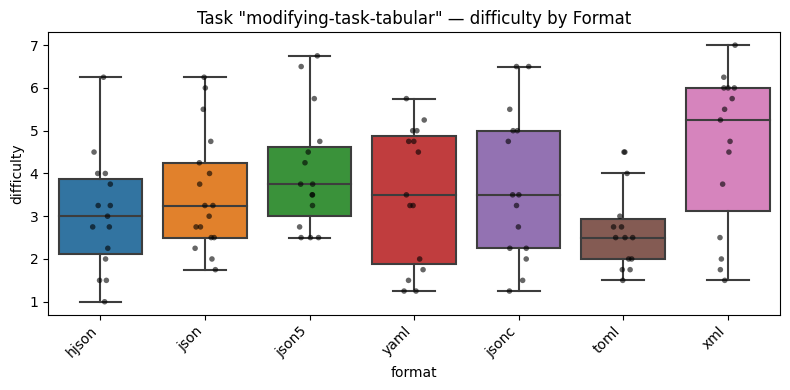

Outliers for "modifying-task-tabular":
               task_group format  difficulty outlier_group  lower_bound  \
0  modifying-task-tabular   toml         4.5          toml      0.59375   
1  modifying-task-tabular   toml         4.5          toml      0.59375   

   upper_bound  
0      4.34375  
1      4.34375  
--------------------------------------------------


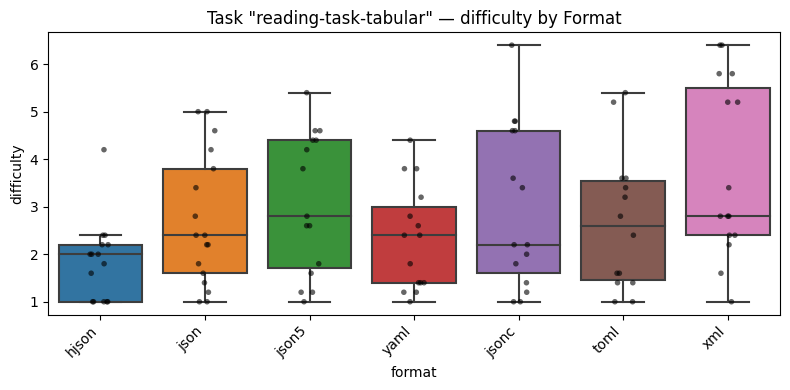

Outliers for "reading-task-tabular":
             task_group format  difficulty outlier_group  lower_bound  \
0  reading-task-tabular  hjson         4.2         hjson         -0.8   

   upper_bound  
0          4.0  
--------------------------------------------------


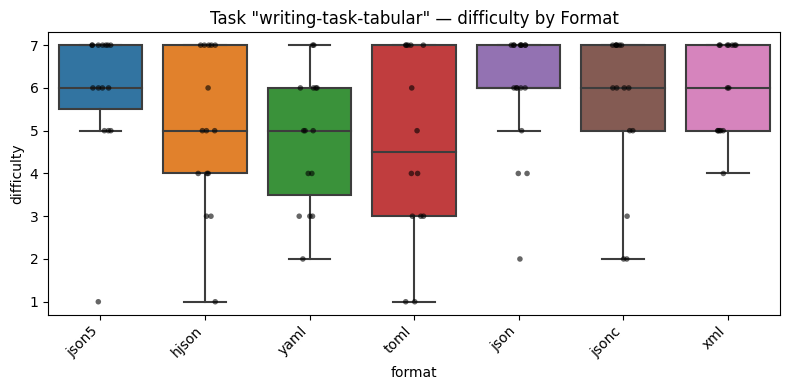

Outliers for "writing-task-tabular":
             task_group format  difficulty outlier_group  lower_bound  \
0  writing-task-tabular   json         4.0          json         4.50   
1  writing-task-tabular   json         4.0          json         4.50   
2  writing-task-tabular   json         2.0          json         4.50   
3  writing-task-tabular  json5         1.0         json5         3.25   

   upper_bound  
0         8.50  
1         8.50  
2         8.50  
3         9.25  
--------------------------------------------------


In [34]:
# 1. 生成 df_proc
df_processed = process_clean_post_tasks(df_clean)

# 2. 定义任务列表
tasks = [
    'modifying-task-tabular',
    'reading-task-tabular',
    # … 其他任务 …
    'writing-task-tabular'
]

# 3. 直接调用
report_task_format_analysis(df_processed, tasks, duration_col='difficulty', alpha=0.05)


In [17]:
sub = df_processed[df_processed['task_group']=='modifying-task-tabular']
print(sub.groupby('format').size())

format
hjson    15
json     17
json5    15
jsonc    15
toml     15
xml      15
yaml     15
dtype: int64


In [25]:
df_processed[df_processed['format']=='toml']

,participantId,format,task,task_group,duration_sec,difficulty,confidence
33,67e5cf90b79d0874e1cf16b0,toml,writing-task-NL,writing-task-NL,8.210,1.00,7.00
34,67e5cf90b79d0874e1cf16b0,toml,reading-task-tabular-1,reading-task-tabular-1,8.030,5.00,4.00
35,67e5cf90b79d0874e1cf16b0,toml,reading-task-tabular-2,reading-task-tabular-2,8.975,5.00,4.00
36,67e5cf90b79d0874e1cf16b0,toml,reading-task-tabular-3,reading-task-tabular-3,3.282,5.00,4.00
37,67e5cf90b79d0874e1cf16b0,toml,reading-task-tabular-4,reading-task-tabular-4,7.554,6.00,4.00
...,...,...,...,...,...,...,...
1360,67bf88cc763aae600b429a3e,toml,NaN,modifying-task-tabular,25.431,2.50,5.75
1364,67d00f24466a67ba7e41228e,toml,NaN,modifying-task-tabular,28.218,2.50,5.00
1381,67e5cf90b79d0874e1cf16b0,toml,NaN,modifying-task-tabular,16.428,2.75,5.75
1382,67eefd0739d752c54dd52686,toml,NaN,modifying-task-tabular,25.183,1.75,6.25


In [27]:
missing_rows = df_processed[df_processed['difficulty'].isna()]
missing_rows

,participantId,format,task,task_group,duration_sec,difficulty,confidence
414,668e88ea6a476e76e0c1993b,toml,modifying-task-tabular-1,modifying-task-tabular-1,NaN,NaN,NaN
415,668e88ea6a476e76e0c1993b,toml,modifying-task-tabular-2,modifying-task-tabular-2,NaN,NaN,NaN
416,668e88ea6a476e76e0c1993b,toml,modifying-task-tabular-3,modifying-task-tabular-3,NaN,NaN,NaN
417,668e88ea6a476e76e0c1993b,toml,modifying-task-tabular-4,modifying-task-tabular-4,NaN,NaN,NaN
1323,668e88ea6a476e76e0c1993b,toml,NaN,modifying-task-tabular,0.0,NaN,NaN


In [21]:
for fmt, grp in df_processed[df_processed['task_group']=='modifying-task-tabular'].groupby('format'):
    print(fmt, grp['difficulty'].unique())


hjson [1.5  4.   2.75 1.   4.5  3.   3.25 6.25 2.25 3.75 2.  ]
json [6.   2.25 2.5  3.   1.75 3.75 2.75 4.75 3.25 4.25 5.5  2.   4.   6.25]
json5 [3.5  4.75 3.75 4.5  4.25 3.25 2.5  5.75 2.75 6.5  6.75]
jsonc [5.   2.75 6.5  2.25 4.75 5.5  3.25 2.   3.5  1.5  1.25]
toml [2.   3.   2.5  4.5   nan 2.75 4.   1.75 1.5 ]
xml [6.   1.75 5.75 7.   2.   4.75 6.25 5.5  4.5  1.5  3.75 5.25 2.5 ]
yaml [1.75 5.25 5.75 4.75 3.25 1.25 5.   1.5  3.5  2.   4.5 ]


In [5]:
# 1. Aggregate tasks (keeping both original and grouped rows)
df_processed = process_clean_post_tasks(df_clean)

# 2. Test metrics across task groups
results = test_post_task_metrics(df_processed)


# 打印每个 task_group 下的解释
for tg, metrics_dict in results.items():
    print(f"\n=== Task Group: {tg} ===")
    for metric, info in metrics_dict.items():
        print(info['interpretation'])
        if info['tukey'] is not None:
            print(info['tukey'].summary())



=== Task Group: writing-task-NL ===
[writing-task-NL] Levene’s p = 0.493 (> 0.05), variances homogeneous. ANOVA p = 0.427 (≥ 0.05): no significant format differences on duration_sec.
[writing-task-NL] Levene’s p = 0.067 (> 0.05), variances homogeneous. ANOVA p = 0.127 (≥ 0.05): no significant format differences on difficulty.
[writing-task-NL] Levene’s p = 0.461 (> 0.05), variances homogeneous. ANOVA p = 0.473 (≥ 0.05): no significant format differences on confidence.

=== Task Group: reading-task-tabular-1 ===
[reading-task-tabular-1] Levene’s p = 0.701 (> 0.05), variances homogeneous. ANOVA p = 0.788 (≥ 0.05): no significant format differences on duration_sec.
[reading-task-tabular-1] Levene’s p = 0.073 (> 0.05), variances homogeneous. ANOVA p = 0.043 (< 0.05): formats differ significantly on difficulty. See Tukey HSD for pairwise.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
-------------------------------------------------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



=== Categorical mappings (excluding q12) ===

q11:
  'Not familiar at all' → 0
  'Somewhat familiar' → 1
  'Very familiar' → 2

q13:
  'Dysgraphia (e.g., difficulty with handwriting or written expression).' → 0
  'Dyslexia (e.g., difficulty reading or distinguishing symbols, such as "b" and "d").' → 1
  'No, I do not have any cognitive-related conditions.' → 2
  'Prefer not to say.' → 3

q13-other:
  '' → 0

q14:
  'Color vision deficiency (CVD) (e.g., difficulty distinguishing colors like red and green).' → 0
  'No, I do not have any related conditions.' → 1
  'Prefer not to say.;No, I do not have any related conditions.' → 2

q14-other:
  '' → 0

q7:
  '' → 0
  "For someone in their 60's this was quite the confusing study, as I have seen these type of lines in movies but never worked with them before, it was an exciting study, dont get me wrong I enjoyed it, but some of those explanations flew right over my head hahaha.\nBut thank you for this, expanding my knowledge is still what I

/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_63974/4038870559.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs['numeric'].show()
/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_63974/4038870559.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_63974/4038870559.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs['q12'].show()


Question: q11
Question: q13
Question: q13-other
Question: q14
Question: q14-other
Question: q7
Question: q8
Question: q9
Question: q9-other


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)


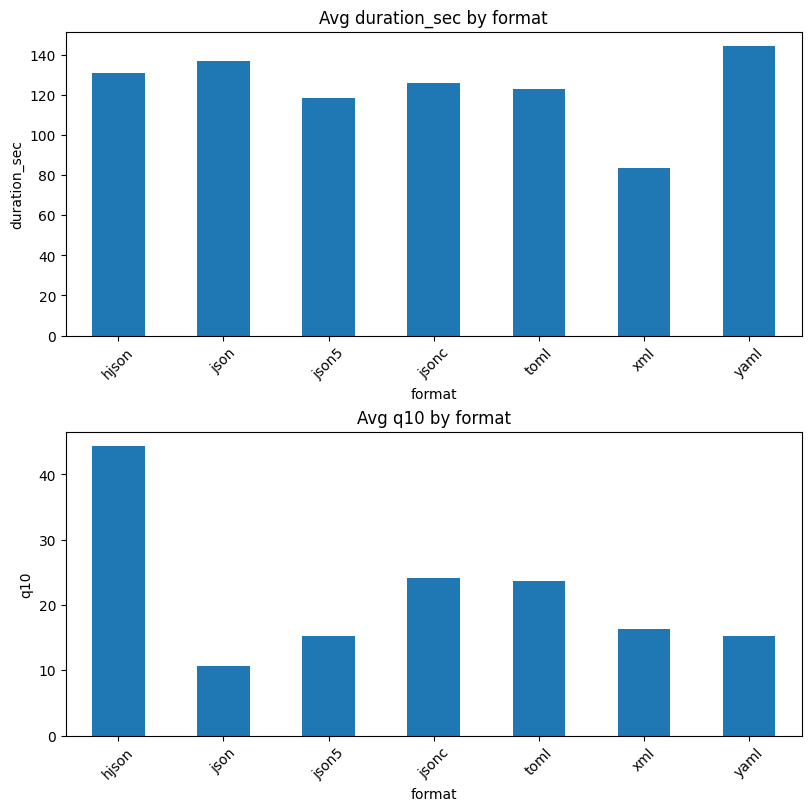

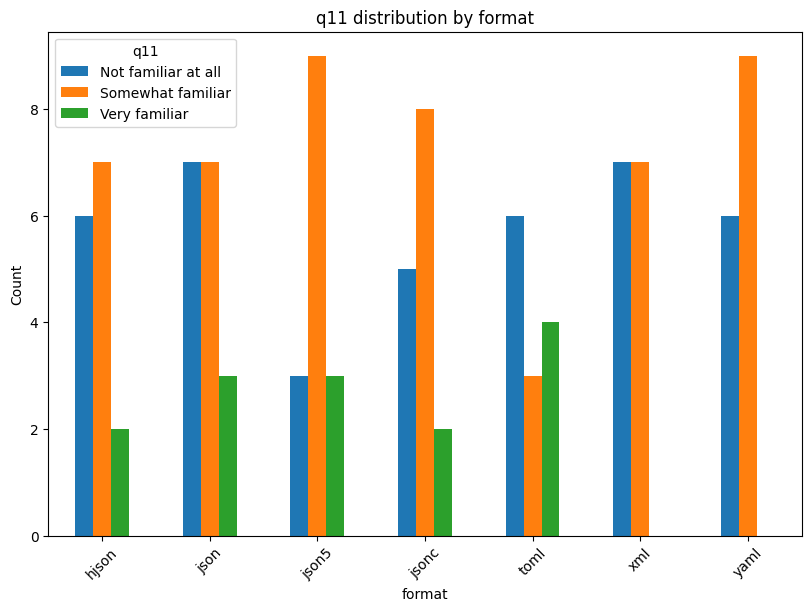

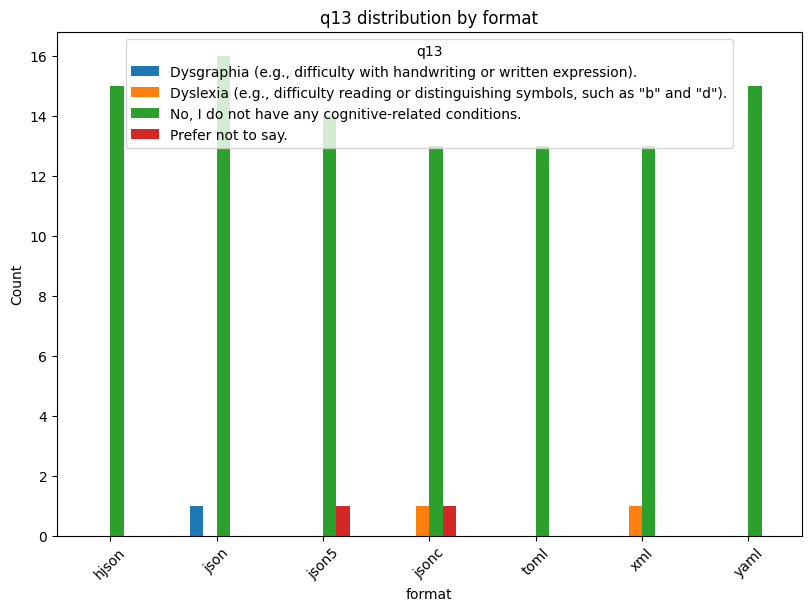

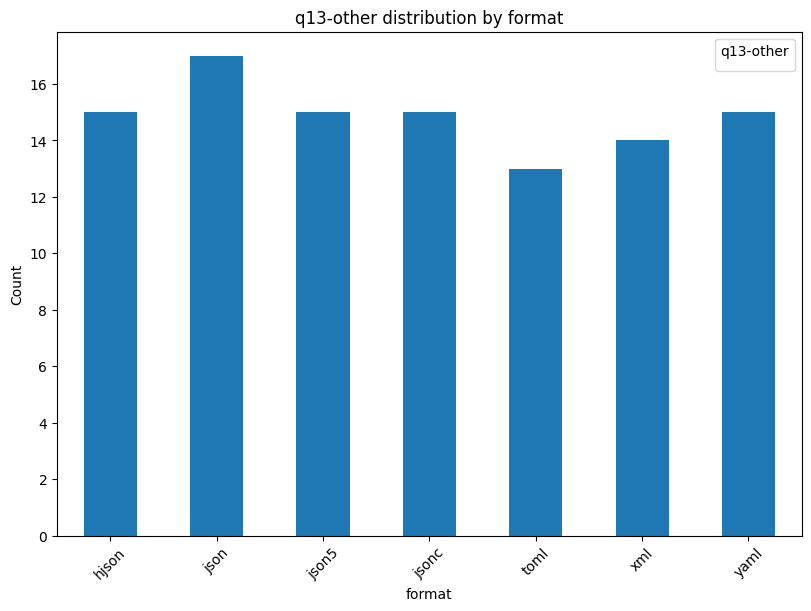

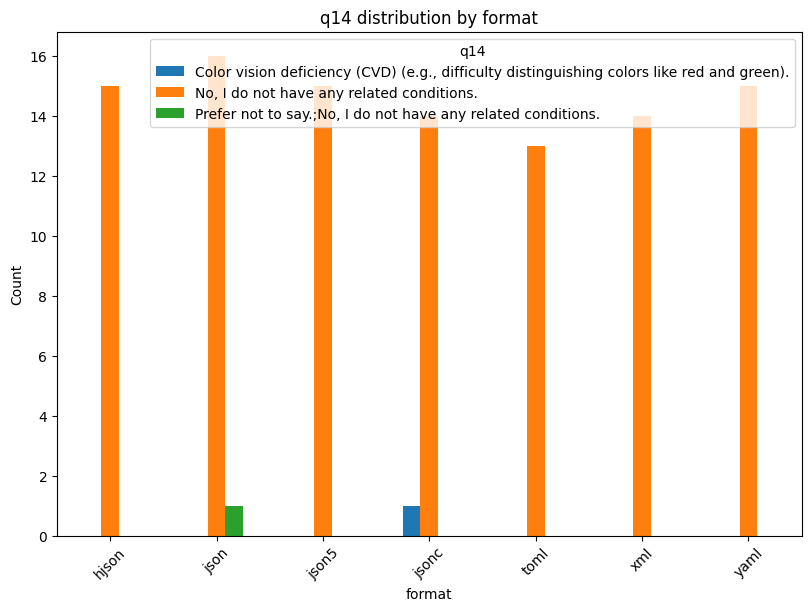

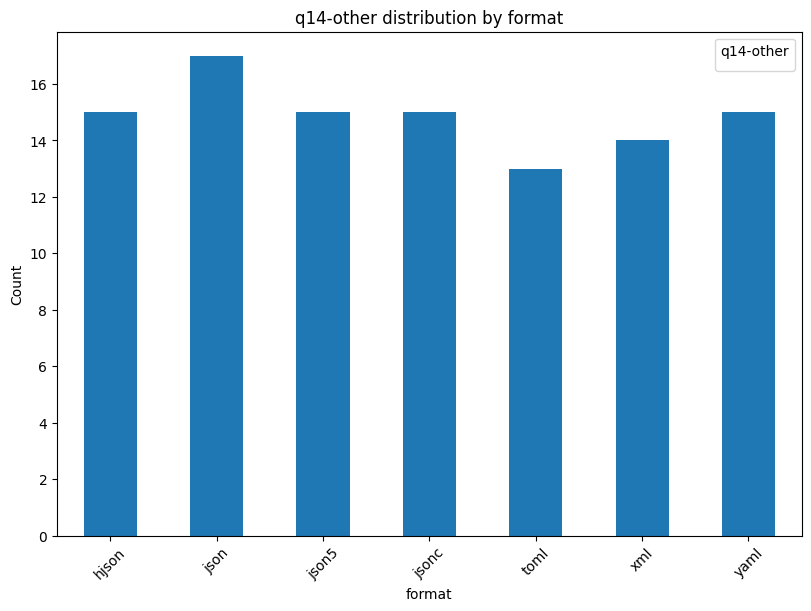

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


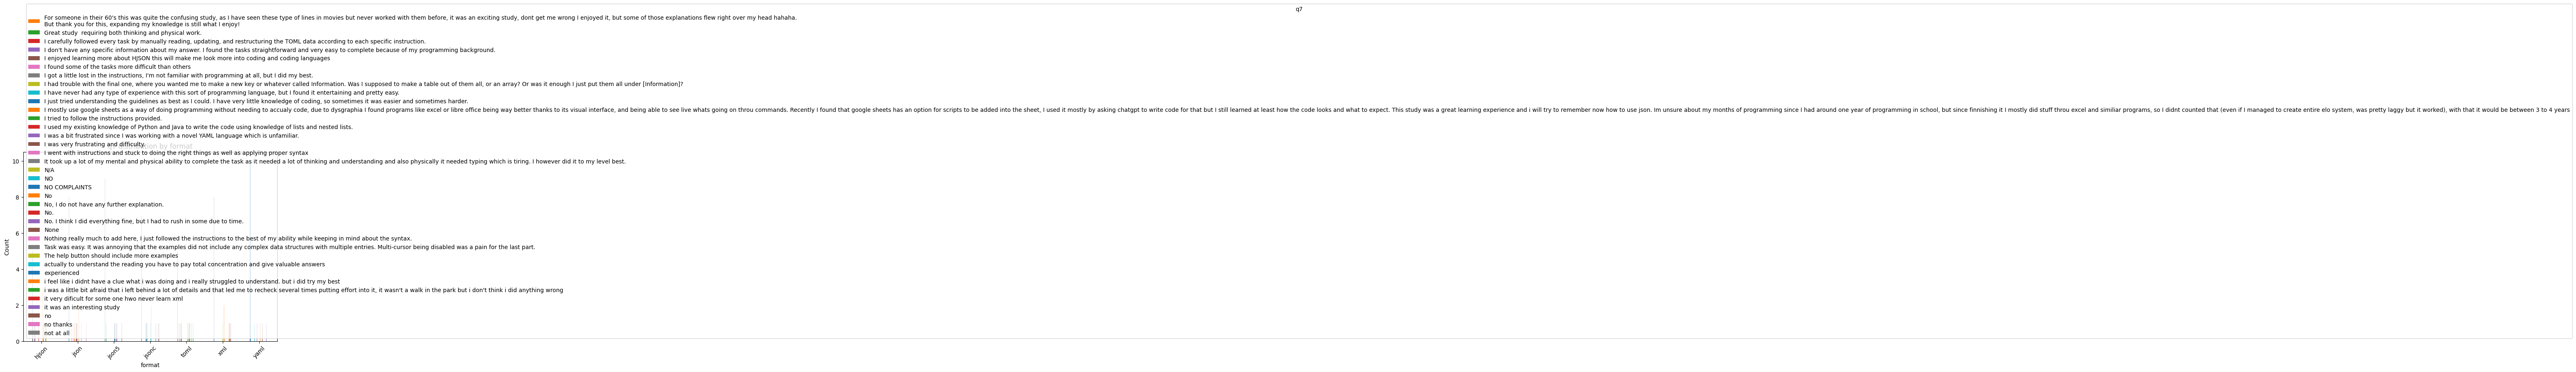

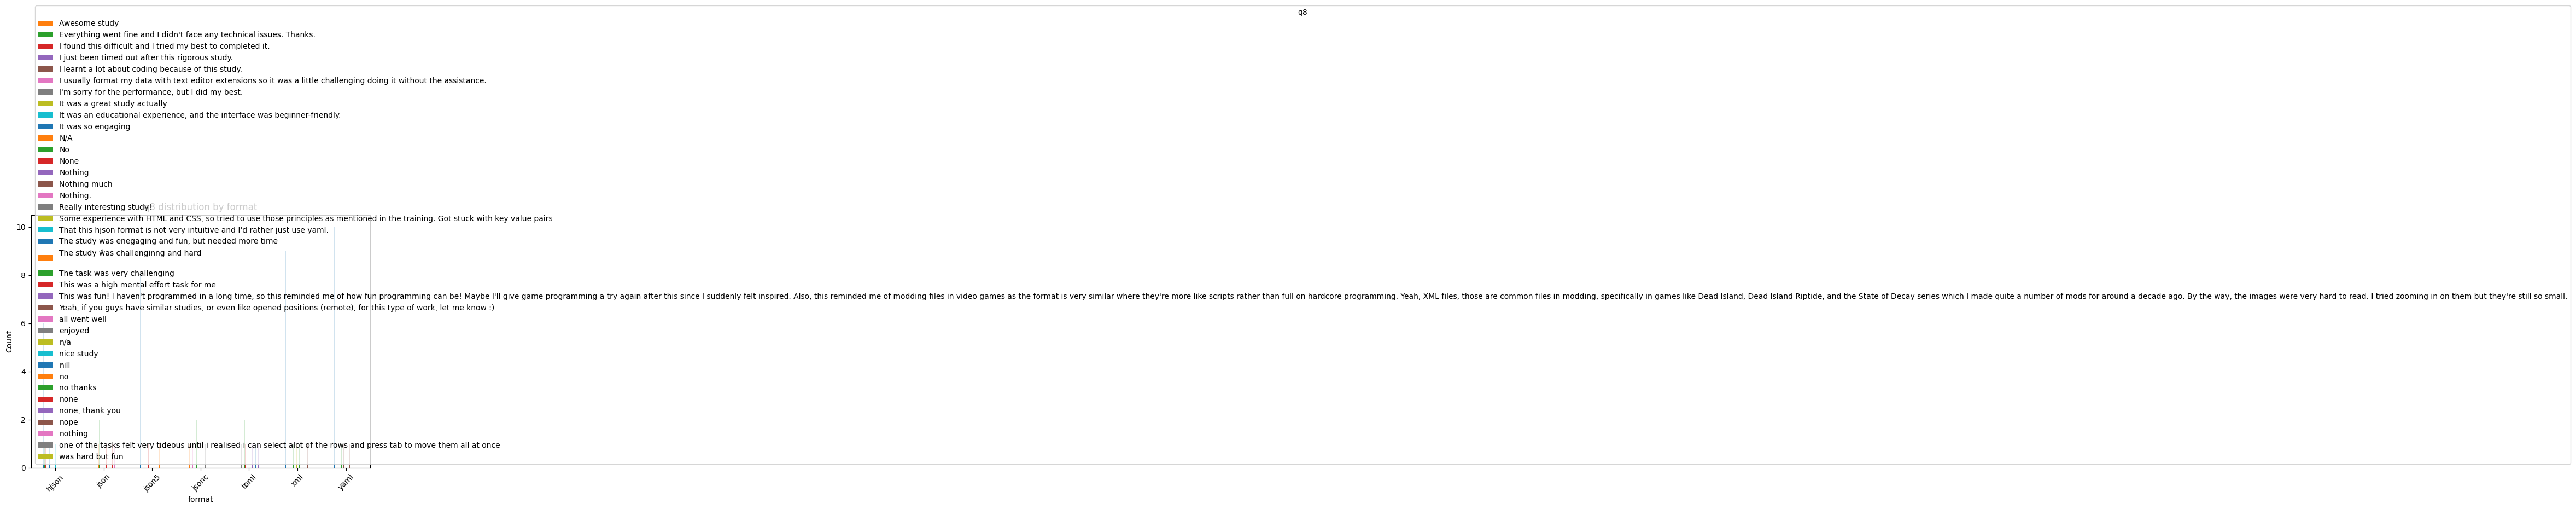

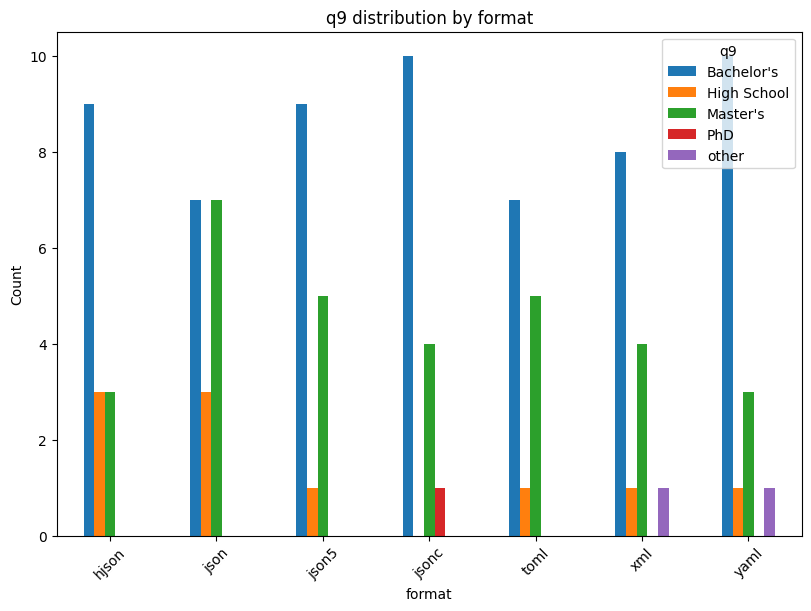

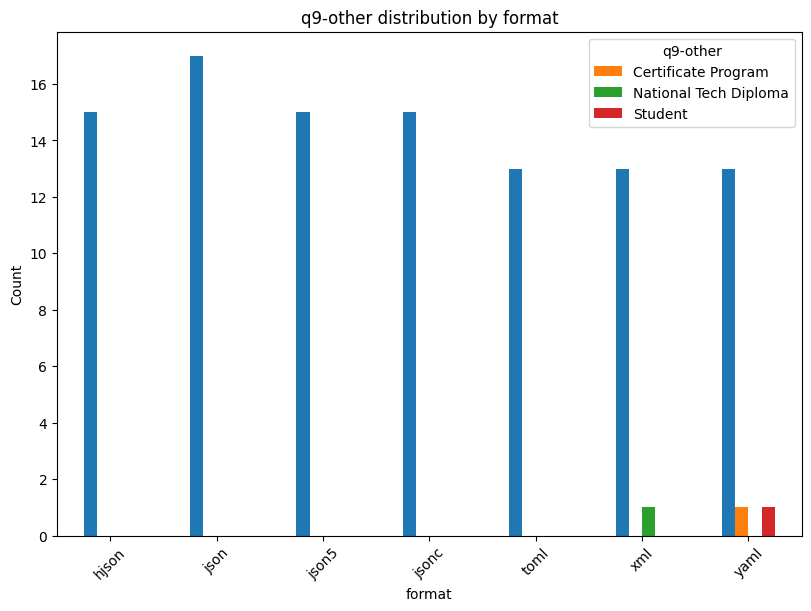

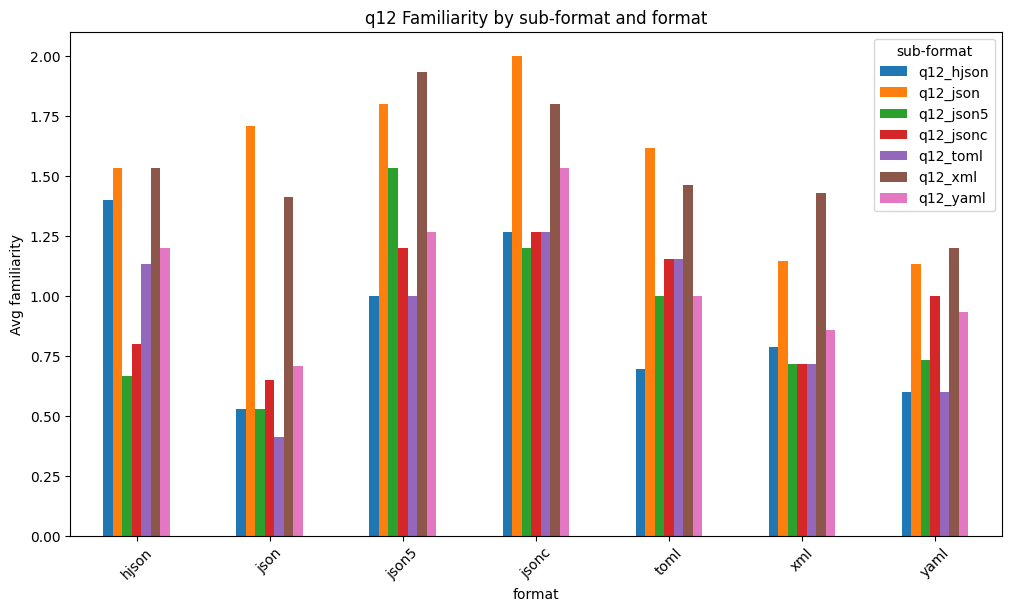

In [6]:
from quiz_evaluator import (
    extract_post_task_survey,
    plot_post_task_survey_by_format
)

# 1. 提取数据
df_survey = extract_post_task_survey(all_data)

# 2. 可视化并获取每个 Figure
figs = plot_post_task_survey_by_format(
    df_survey,
    format_list=['json', 'xml', 'hjson', 'yaml','jsonc', 'json5', 'toml']
)

# 3. 展示
figs['numeric'].show()
for q, fig in figs['categorical'].items():
    print("Question:", q)
    fig.show()
figs['q12'].show()

In [13]:
print(df_survey)

                participantId format                  task      startTime  \
0    6697c8b6d9d7baa7edd8c4d3  hjson  post-task-survey-tlx  1745933980597   
1    67e25388d573ec2d5f1c8442   yaml  post-task-survey-tlx  1746148206548   
2    67e5cf90b79d0874e1cf16b0   toml  post-task-survey-tlx  1746147510413   
3    67d00f24466a67ba7e41228e   toml  post-task-survey-tlx  1745933383518   
4    66475d6f7b27e4443ef0d031   json  post-task-survey-tlx  1744922093386   
..                        ...    ...                   ...            ...   
97   67ab650c320eccf6141d4010  jsonc  post-task-survey-tlx  1746147520202   
98   65fad673a546ab14baf2f8d3  json5  post-task-survey-tlx  1745932138030   
99   67f1c7bd6f1c4a3d8deae02f   toml  post-task-survey-tlx  1746146719288   
100  67adb27bd5f5776fcb16da62  hjson  post-task-survey-tlx  1746147560523   
101  6675c40cdc52b37294f0514e  hjson  post-task-survey-tlx  1746235958794   

           endTime  duration_sec  \
0    1745934152435       171.838   
1  